In [1]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sample_data
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('AusAntidiabeticDrug.csv')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


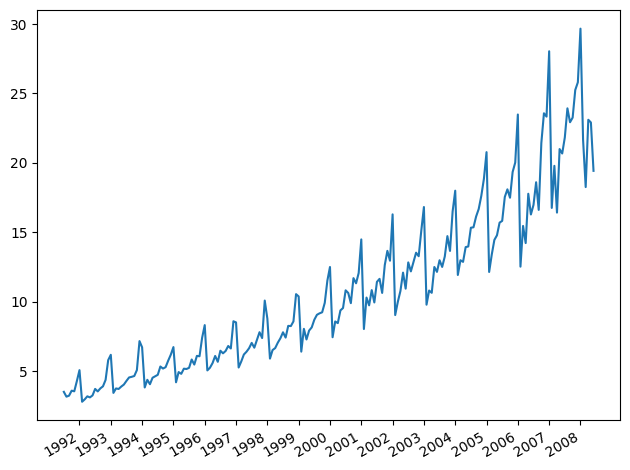

In [4]:
fig,ax = plt.subplots()
ax.plot(df.y)
plt.xticks(np.arange(6,203,12),np.arange(1992,2009,1))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

DECOMPOSITION


In [5]:
decomposition = STL(df.y,period=12).fit()

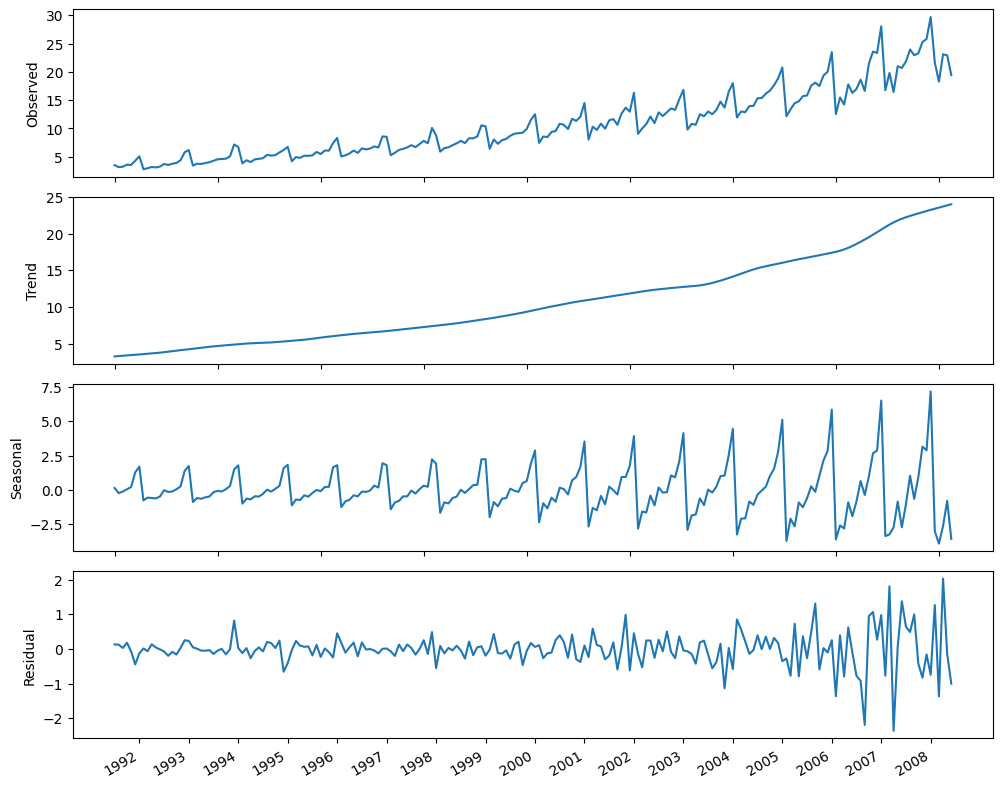

In [6]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
plt.xticks(np.arange(6,203,12),np.arange(1992,2009,1))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [7]:
ad_fuller = adfuller(df.y)
print(f'ADF Statistic: {ad_fuller[0]}')
print(f'p-value: {ad_fuller[1]}')

ADF Statistic: 3.145185689306745
p-value: 1.0


In [8]:
y_diff = np.diff(df.y)
adf_diff = adfuller(y_diff)
print(f'ADF Statistic: {adf_diff[0]}')
print(f'p-value: {adf_diff[1]}')

ADF Statistic: -2.4951721474497903
p-value: 0.1166534168646754


In [9]:
y_seasonal_diff = np.diff(y_diff,n=12)
adf_seasonal_diff = adfuller(y_seasonal_diff)
print(f'ADF Statistic: {adf_seasonal_diff[0]}')
print(f'p-value: {adf_seasonal_diff[1]}')

ADF Statistic: -19.84844009618371
p-value: 0.0


In [10]:
train = df.y[:168]
test = df.y[168:]

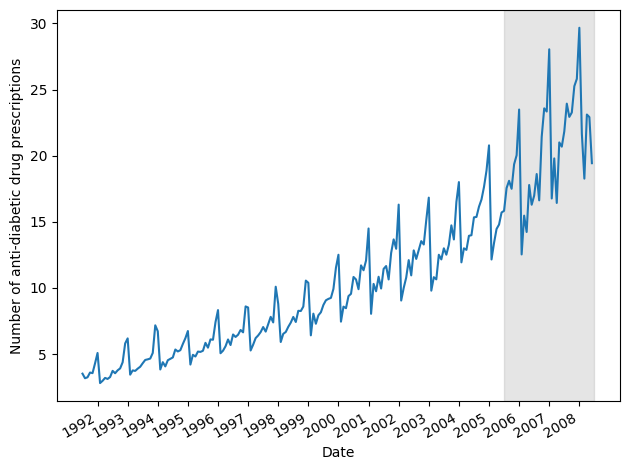

In [11]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()


SARIMAX

In [12]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
  result = []
  for order in tqdm_notebook(order_list):
    try:
      model = SARIMAX(endog,exog,order=(order[0],d,order[1]),seasonal_order=(order[2],D,order[3],s),simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    result.append([order,aic])

  result_df = pd.DataFrame(result)
  result_df.columns = ['(p,q,P,Q)','aic']
  result_df = result_df.sort_values(by='aic',ascending=True).reset_index(drop=True)

  return result_df



In [13]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [14]:
# order_list = list(product(ps, qs, Ps, Qs))
# sarima_result_df = optimize_SARIMAX(train,None,order_list,d,D,s)
# sarima_result_df

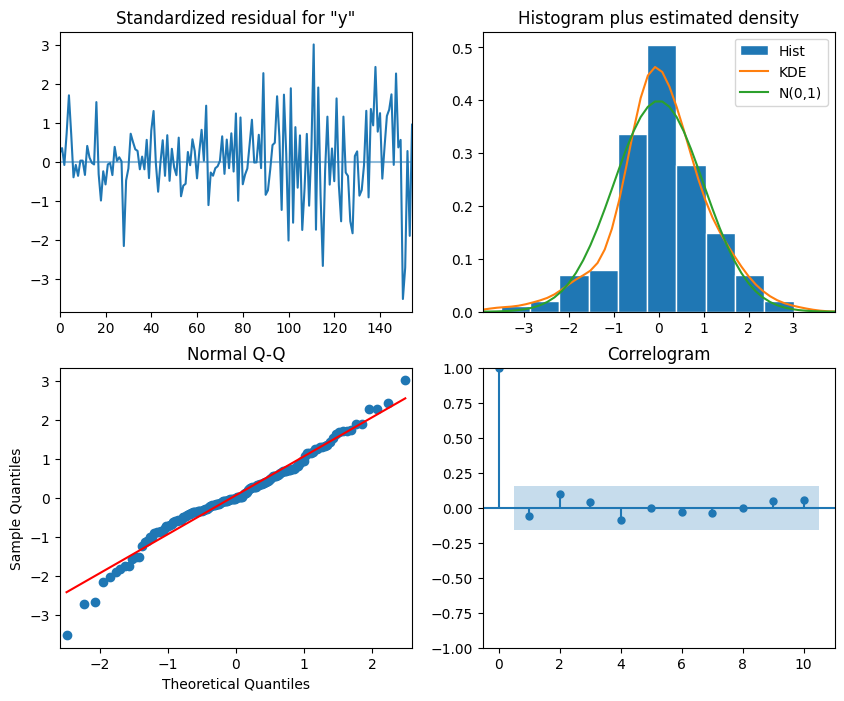

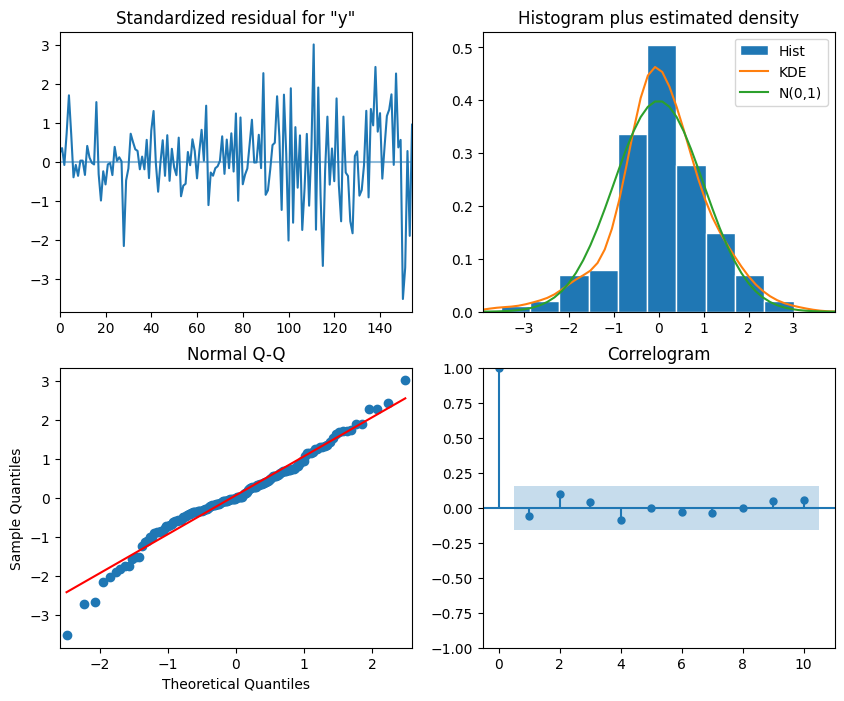

In [15]:
SARIMA_model = SARIMAX(train,order=(2,1,3),seasonal_order=(1,1,3,12),simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [16]:
residuals = SARIMA_model_fit.resid
lbvalue,pvalue = acorr_ljungbox(residuals,np.arange(1,11,1))
print(pvalue)

lb_pvalue


FORECAST


In [17]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []

        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)

        return pred_last_season

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [18]:
pred_df = df[168:]

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [19]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [20]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.749386
169,2005-08-01,17.554701,15.370764,16.684883
170,2005-09-01,18.100864,16.142005,17.188720
171,2005-10-01,17.496668,16.685754,18.088932
172,2005-11-01,19.347265,17.636728,18.657838
173,2005-12-01,20.031291,18.869325,19.948363
174,2006-01-01,23.486694,20.778723,22.075817
175,2006-02-01,12.536987,12.154552,13.745806
176,2006-03-01,15.467018,13.402392,15.086059
177,2006-04-01,14.233539,14.459239,15.657270


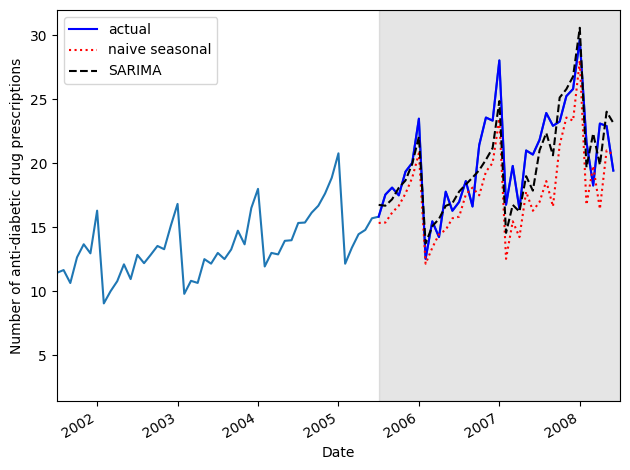

In [21]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()


EVALUTE

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.898811951220185


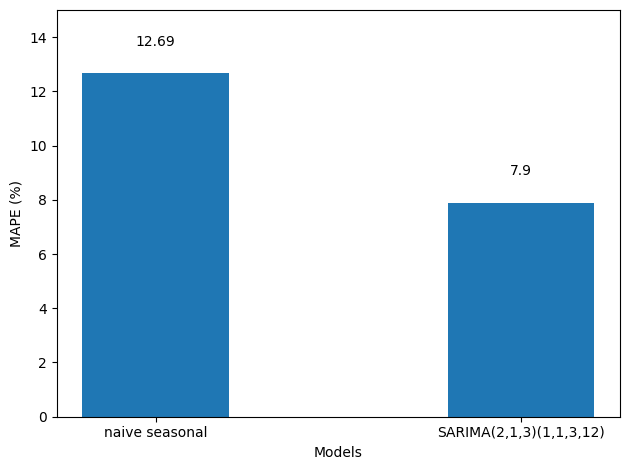

In [24]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()